In [ ]:
!pip install numpy pandas scikit-learn torch transformers sentence-transformers nltk matplotlib seaborn scipy



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### IMPORT ALL LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import torch
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import pos_tag, word_tokenize
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from sentence_transformers import SentenceTransformer
from transformers import T5EncoderModel, T5Tokenizer, CLIPTokenizer, CLIPTextModel
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /Users/prisha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/prisha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### LOAD DATASET

In [5]:
stimuli = [line.strip() for line in open('data/stimuli.txt').readlines()]
subj1 = np.load('data/subj1.npy', allow_pickle=True).item()
subj2 = np.load('data/subj2.npy', allow_pickle=True).item()
subjects = {'subj1': subj1, 'subj2': subj2}
ROIs = ['language', 'vision', 'task', 'dmn']

print(f"Number of stimuli: {len(stimuli)}")
print(f"Length of Subject 1 data: {len(subj1)}")
print(f"Length of Subject 2 data: {len(subj2)}")
print(f"Keys in Subject 1 data: {list(subj1.keys())}") 
print(f"Keys in Subject 2 data: {list(subj2.keys())}") 

Number of stimuli: 627
Length of Subject 1 data: 4
Length of Subject 2 data: 4
Keys in Subject 1 data: ['language', 'vision', 'dmn', 'task']
Keys in Subject 2 data: ['language', 'vision', 'dmn', 'task']


In [17]:
#  See the length of fmri embeddings

print(len(subj1['language'][0]))

11437


### SENTENCE EMBEDDING

In [6]:
sbert_model1 = SentenceTransformer('all-MiniLM-L6-v2') 
sbert_model2 = SentenceTransformer('all-mpnet-base-v2')
t5_model = T5EncoderModel.from_pretrained('t5-small')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
clip_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
clip_model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
def get_t5_embeddings(sentences):
    inputs = t5_tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = t5_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()


In [8]:
def get_clip_embeddings(sentences):
    inputs = clip_tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = clip_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

In [9]:
print("Generating Embeddings...")
sbert_embeddings1 = sbert_model1.encode(stimuli, show_progress_bar=True)
sbert_embeddings2 = sbert_model2.encode(stimuli, show_progress_bar=True)
t5_embeddings = get_t5_embeddings(stimuli)
clip_embeddings = get_clip_embeddings(stimuli)

print("Calculating Length of Embeddings...")   
sbert_embeddings_len1 = len(sbert_embeddings1)
sbert_embeddings2_len2 = len(sbert_embeddings2)
t5_embeddings_len = len(t5_embeddings)
clip_embeddings_len = len(clip_embeddings)

print(f"Length of SBERT Embeddings: {sbert_embeddings_len1}")
print(f"Length of SBERT Embeddings: {sbert_embeddings2_len2}")
print(f"Length of T5 Embeddings: {t5_embeddings_len}")
print(f"Length of CLIP Embeddings: {clip_embeddings_len}")

# Print Length of each embedding
print(f"Length of SBERT Embeddings: {sbert_embeddings1.shape}")
print(f"Length of SBERT Embeddings: {sbert_embeddings2.shape}")
print(f"Length of T5 Embeddings: {t5_embeddings.shape}")    
print(f"Length of CLIP Embeddings: {clip_embeddings.shape}")


Generating Embeddings...


Batches: 100%|██████████| 20/20 [00:03<00:00,  5.87it/s]


Calculating Length of Embeddings...
Length of SBERT Embeddings: 627
Length of SBERT Embeddings: 627
Length of T5 Embeddings: 627
Length of CLIP Embeddings: 627
Length of SBERT Embeddings: (627, 384)
Length of SBERT Embeddings: (627, 768)
Length of T5 Embeddings: (627, 512)
Length of CLIP Embeddings: (627, 512)


In [10]:

# Combine all embeddings
embeddings = {
    'SBERT1': sbert_embeddings1,
    'SBERT2': sbert_embeddings2,
    'T5': t5_embeddings,
    'CLIP': clip_embeddings
}

### EVALUATION METRICS

In [11]:
def cosine_distance(u, v):
    return 1 - cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0][0]

def v2v_accuracy(y_true, y_pred):
    N = len(y_true)
    correct = 0
    for i in range(0, N, 2):
        if i + 1 >= N:
            break
        score1 = cosine_similarity(y_true[i].reshape(1, -1), y_pred[i].reshape(1, -1))[0][0] + \
                 cosine_similarity(y_true[i+1].reshape(1, -1), y_pred[i+1].reshape(1, -1))[0][0]
        score2 = cosine_similarity(y_true[i].reshape(1, -1), y_pred[i+1].reshape(1, -1))[0][0] + \
                 cosine_similarity(y_true[i+1].reshape(1, -1), y_pred[i].reshape(1, -1))[0][0]
        if score1 > score2:
            correct += 1
    return correct / (N // 2)

def pearson_corr(y_true, y_pred):
    return np.mean([pearsonr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])])

In [ ]:
def train_encoder(X, Y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    v2v_scores = []
    pc_scores = []
    
    for train_idx, test_idx in kf.split(X):
        model = Ridge(alpha=1.0)
        model.fit(X[train_idx], Y[train_idx])
        preds = model.predict(X[test_idx])
        
        v2v_scores.append(v2v_accuracy(Y[test_idx], preds))
        pc_scores.append(pearson_corr(Y[test_idx], preds))
    
    return np.mean(v2v_scores), np.mean(pc_scores)

In [ ]:
def mask_pos(sentences, target_pos):
    """
    Mask the specified part-of-speech (POS) tags in the sentences.
    Args:
        sentences (list of str): List of sentences to mask.
        target_pos (str): The POS tag to mask (e.g., 'NN', 'VB').
    Returns:
        list of str: List of sentences with the specified POS tags masked.
    """
    masked = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tags = pos_tag(tokens)
        new_tokens = [token for token, pos in tags if not pos.startswith(target_pos)]
        masked.append(' '.join(new_tokens))
    return masked

In [21]:
# Test example
sentences = [
    "The cat sat on the mat.",
    "He runs quickly through the park.",
    "She enjoys reading books."
]

# Mask all nouns (POS tag starts with 'NN')
masked_nouns = mask_pos(sentences, 'NN')
print("Masked Nouns:", masked_nouns)

# Mask all verbs (POS tag starts with 'VB')
masked_verbs = mask_pos(sentences, 'VB')
print("Masked Verbs:", masked_verbs)

Masked Nouns: ['The sat on the .', 'He runs quickly through the .', 'She enjoys reading .']
Masked Verbs: ['The cat on the mat .', 'He quickly through the park .', 'She books .']


In [ ]:
def representational_similarity(X, Y):
    sim_X = cosine_similarity(X)
    sim_Y = cosine_similarity(Y)
    return spearmanr(sim_X.flatten(), sim_Y.flatten())[0]

In [18]:
results = []

for subj_name, subj_data in subjects.items():
    for roi in ROIs:
        print(f"Training for {subj_name} - {roi}")
        Y = subj_data[roi]
        
        for emb_name, X in embeddings.items():
            v2v, pc = train_encoder(X, Y)
            rsa = representational_similarity(X, Y)
            results.append({
                'Subject': subj_name,
                'ROI': roi,
                'Embedding': emb_name,
                '2V2 Accuracy': v2v,
                'Pearson Correlation': pc,
                'RSA': rsa
            })

results_df = pd.DataFrame(results)
print(results_df)

Training for subj1 - language
Training for subj1 - vision
Training for subj1 - task
Training for subj1 - dmn
Training for subj2 - language
Training for subj2 - vision
Training for subj2 - task
Training for subj2 - dmn
   Subject       ROI Embedding  2V2 Accuracy  Pearson Correlation       RSA
0    subj1  language    SBERT1      0.830056             0.305247  0.016020
1    subj1  language    SBERT2      0.852739             0.336211 -0.018143
2    subj1  language        T5      0.785100             0.289146 -0.121716
3    subj1  language      CLIP      0.718228             0.187125  0.120852
4    subj1    vision    SBERT1      0.788377             0.300555  0.030532
5    subj1    vision    SBERT2      0.794777             0.330336  0.009921
6    subj1    vision        T5      0.759396             0.305798 -0.097576
7    subj1    vision      CLIP      0.724578             0.204458  0.098814
8    subj1      task    SBERT1      0.740143             0.226825  0.033572
9    subj1      task  

In [20]:
results_df.to_csv('results_non_masked_encoder.csv', index=False)
print("Results saved to 'results.csv'")

Results saved to 'results.csv'


### VISUALISATION - WITHOUT MASKING 

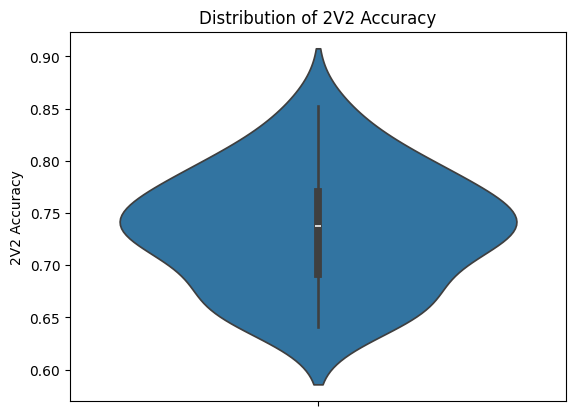

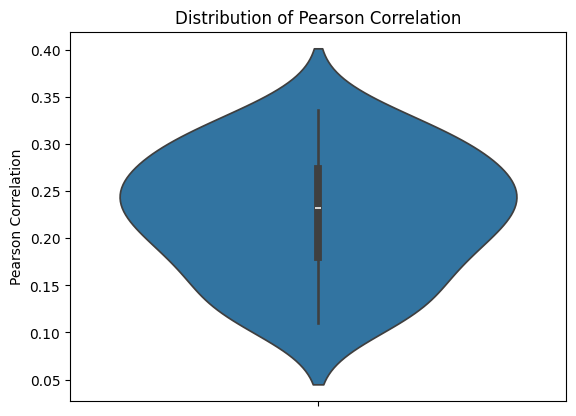

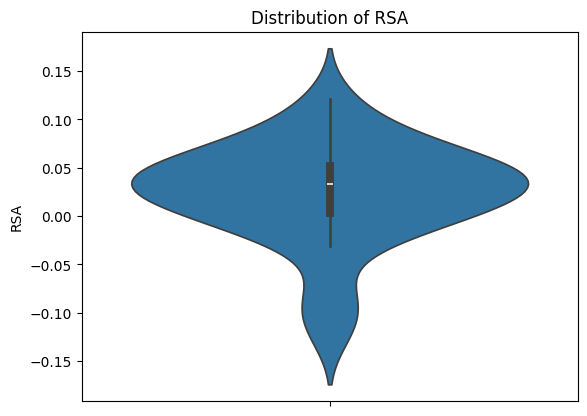

In [22]:
for metric in ['2V2 Accuracy', 'Pearson Correlation', 'RSA']:
    sns.violinplot(data=results_df, y=metric)
    plt.title(f'Distribution of {metric}')
    plt.show()

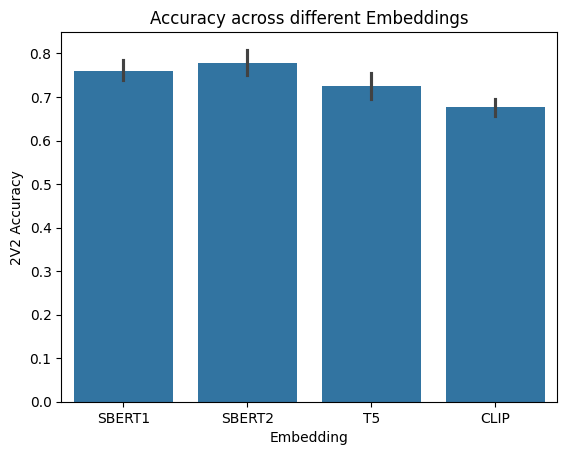

In [23]:
sns.barplot(data=results_df, x='Embedding', y='2V2 Accuracy')
plt.title('Accuracy across different Embeddings')
plt.show()


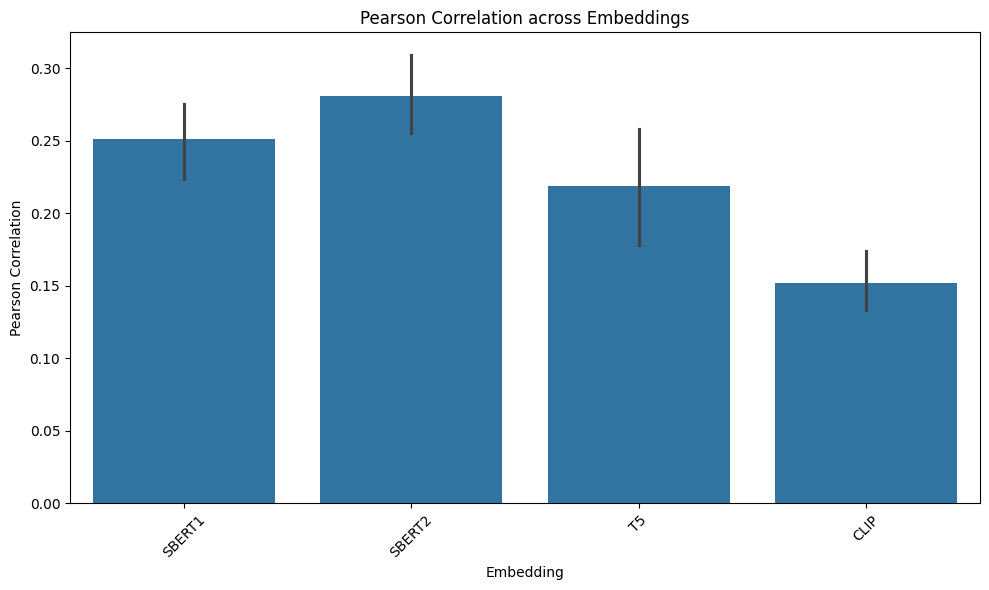

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Embedding', y='Pearson Correlation')  # or ci=95 for CI
plt.title('Pearson Correlation across Embeddings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

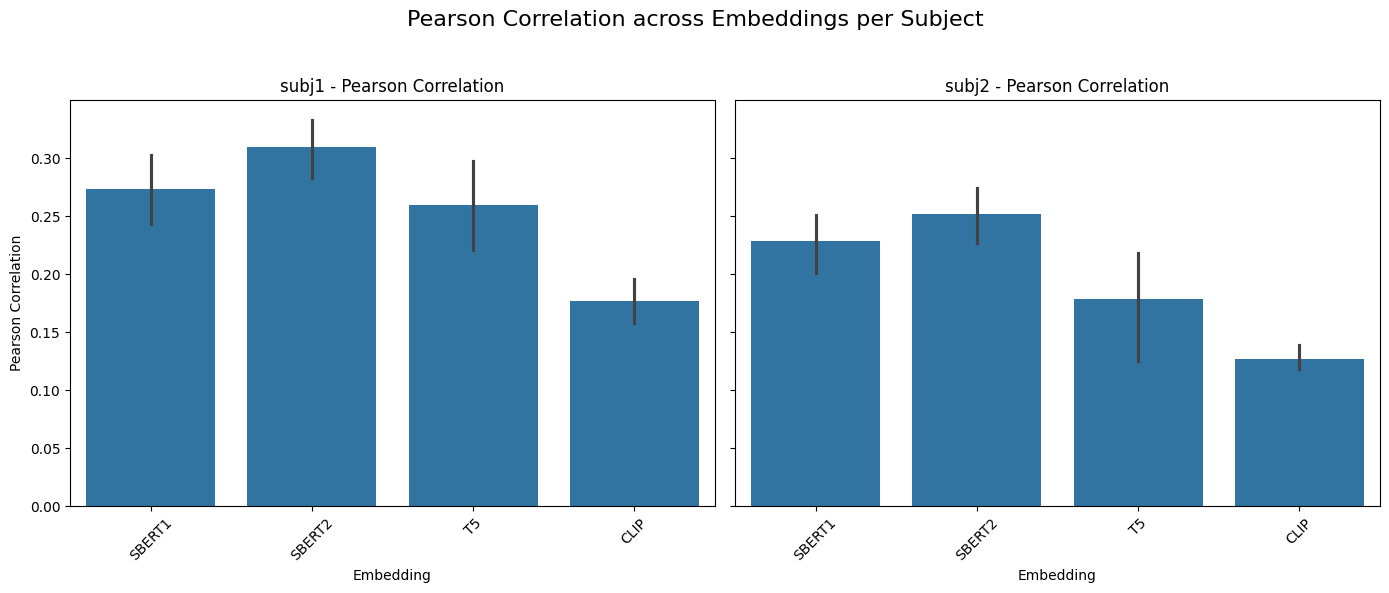

In [52]:
subjects = results_df['Subject'].unique()
fig, axs = plt.subplots(1, len(subjects), figsize=(14, 6), sharey=True)

for i, subj in enumerate(subjects):
    subj_data = results_df[results_df['Subject'] == subj]
    
    sns.barplot(data=subj_data, x='Embedding', y='Pearson Correlation', ax=axs[i])
    axs[i].set_title(f'{subj} - Pearson Correlation')
    axs[i].tick_params(axis='x', rotation=45)

plt.suptitle('Pearson Correlation across Embeddings per Subject', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

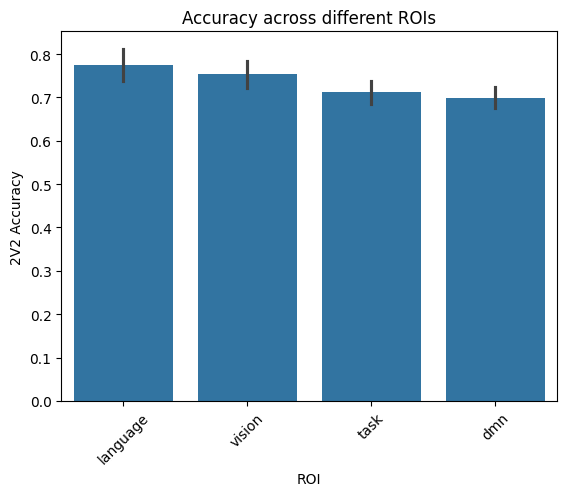

In [27]:
sns.barplot(data=results_df, x='ROI', y='2V2 Accuracy')
plt.title('Accuracy across different ROIs')
plt.xticks(rotation=45)
plt.show()


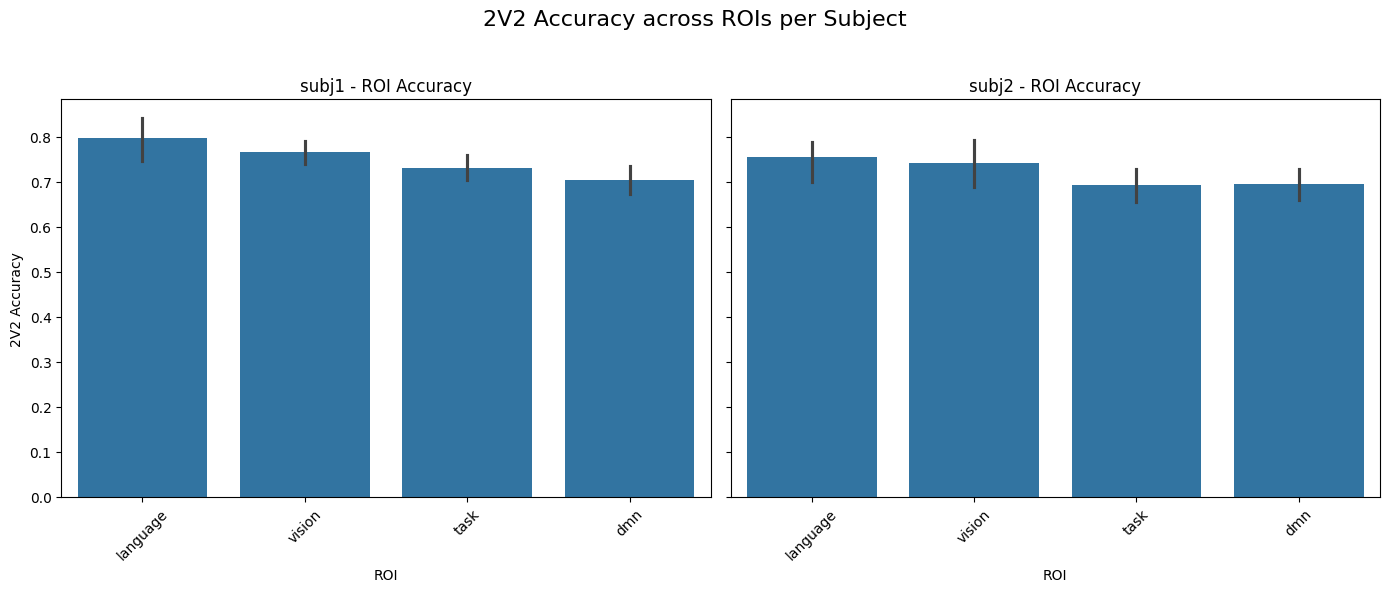

In [51]:
subjects = results_df['Subject'].unique()
fig, axs = plt.subplots(1, len(subjects), figsize=(14, 6), sharey=True)

for i, subj in enumerate(subjects):
    subj_data = results_df[results_df['Subject'] == subj]
    
    sns.barplot(data=subj_data, x='ROI', y='2V2 Accuracy', ax=axs[i])
    axs[i].set_title(f'{subj} - ROI Accuracy')
    axs[i].tick_params(axis='x', rotation=45)

plt.suptitle('2V2 Accuracy across ROIs per Subject', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

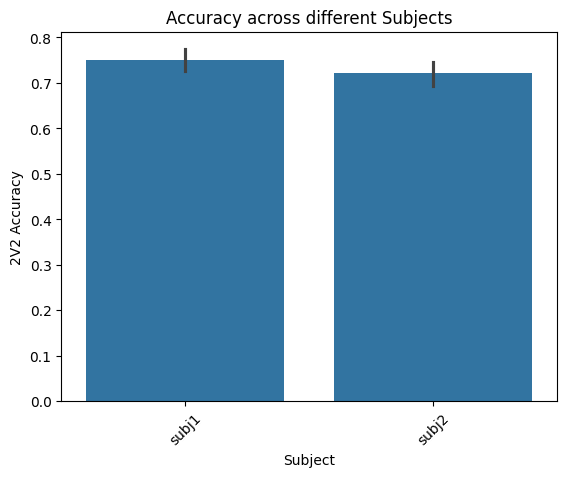

In [28]:
sns.barplot(data=results_df, x='Subject', y='2V2 Accuracy')
plt.title('Accuracy across different Subjects')
plt.xticks(rotation=45)
plt.show()

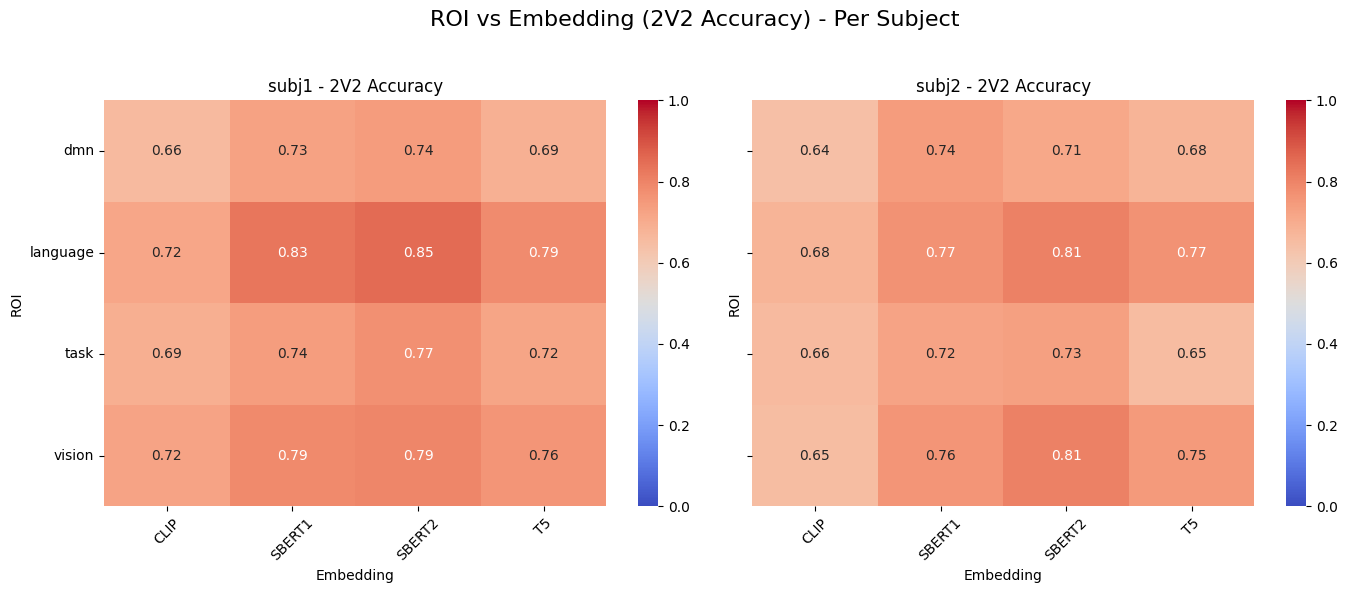

In [50]:
subjects = results_df['Subject'].unique()
fig, axs = plt.subplots(1, len(subjects), figsize=(14, 6), sharey=True)

for i, subj in enumerate(subjects):
    subj_data = results_df[results_df['Subject'] == subj]
    pivot = subj_data.pivot_table(index='ROI', columns='Embedding', values='2V2 Accuracy')

    sns.heatmap(pivot, annot=True, cmap='coolwarm', vmin=0, vmax=1, ax=axs[i])
    axs[i].set_title(f'{subj} - 2V2 Accuracy')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].tick_params(axis='y', rotation=0)

plt.suptitle('ROI vs Embedding (2V2 Accuracy) - Per Subject', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

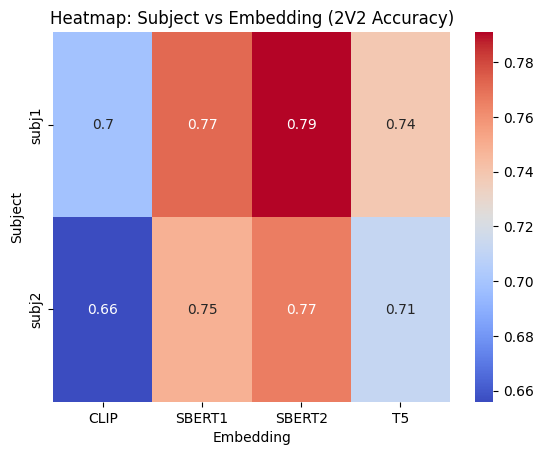

In [32]:
pivot2 = results_df.pivot_table(index='Subject', columns='Embedding', values='2V2 Accuracy')
sns.heatmap(pivot2, annot=True, cmap='coolwarm')
plt.title('Heatmap: Subject vs Embedding (2V2 Accuracy)')
plt.show()

### Key Takeaways

- **Language ROI excels with embeddings:**
        - **CLIP:** Achieves 0.70, which is its best performance across all ROIs.
        - **SBERT2:** Peaks at 0.83, showcasing its strength in modeling language-related brain activations.
        - This suggests that language areas in the brain are better predicted by sentence-level embeddings like SBERT.

- **CLIP's limitations across ROIs:**
        - Consistently shows the lowest accuracy, e.g., 0.65 in DMN and 0.67 in Task.
        - Likely due to its training focus on vision-language alignment, which is less suited for fine-grained sentence semantics or brain responses.

- **Surprising performance in Vision ROI:**
        - Sentence-based embeddings like **SBERT2 (0.80)** and **SBERT1 (0.77)** perform well.
        - Indicates that semantic context contributes to predicting activations in regions beyond traditional language areas.

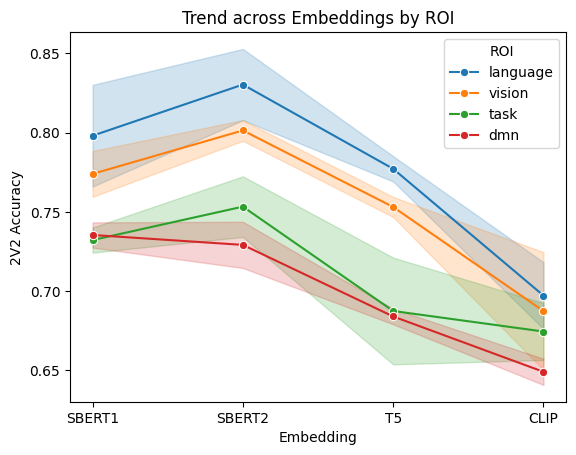

In [49]:
# overall
sns.lineplot(data=results_df, x='Embedding', y='2V2 Accuracy', hue='ROI', marker='o')
plt.title('Trend across Embeddings by ROI')
plt.show()


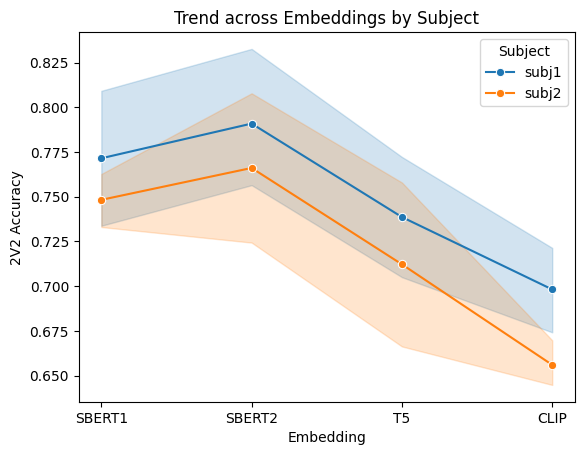

In [ ]:
# overall trend
sns.lineplot(data=results_df, x='Embedding', y='2V2 Accuracy', hue='Subject', marker='o')
plt.title('Trend across Embeddings by Subject')
plt.show()

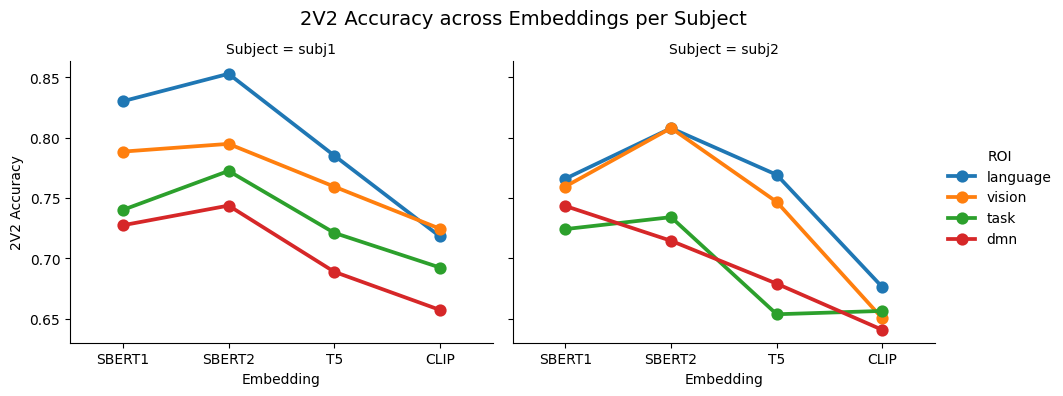

In [ ]:
#  verify if it same for each subject

sns.catplot(
    data=results_df,
    x='Embedding',
    y='2V2 Accuracy',
    kind='point',
    hue='ROI',             # Optional: to see ROI-wise trends too
    col='Subject',
    col_wrap=2,
    height=4,
    aspect=1.2,
    markers='o'
)

plt.subplots_adjust(top=0.85)
plt.suptitle('2V2 Accuracy across Embeddings per Subject', fontsize=14)
plt.show()

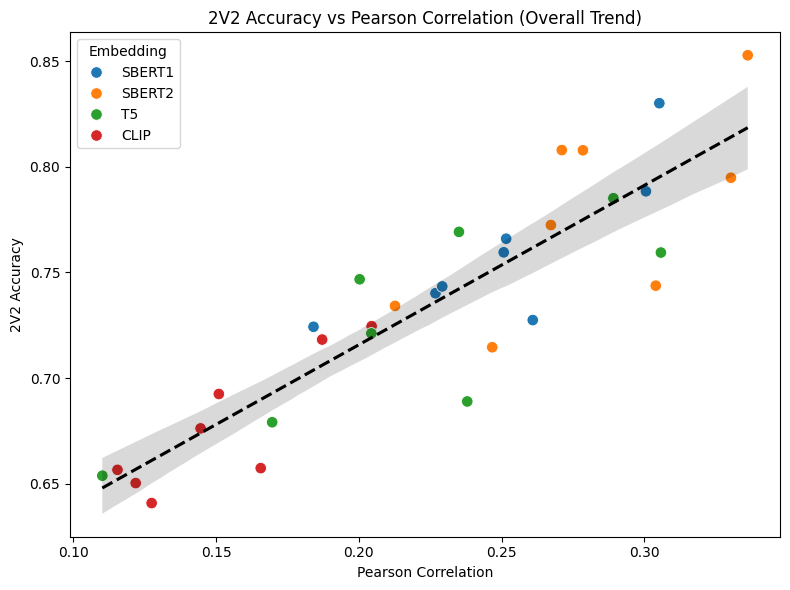

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='Pearson Correlation', y='2V2 Accuracy', hue='Embedding', s=70)
sns.regplot(data=results_df, x='Pearson Correlation', y='2V2 Accuracy', scatter=False, color='black', line_kws={'linestyle':'--'})
plt.title('2V2 Accuracy vs Pearson Correlation (Overall Trend)')
plt.tight_layout()
plt.show()

In [38]:
from scipy.stats import pearsonr
corr, _ = pearsonr(results_df['Pearson Correlation'], results_df['2V2 Accuracy'])
print(f"Overall Pearson correlation between 2V2 Accuracy and Pearson Coefficient: {corr:.3f}")

Overall Pearson correlation between 2V2 Accuracy and Pearson Coefficient: 0.891


- We use `pearsonr` to calculate the correlation between `2V2 Accuracy` and `Pearson Correlation`. The computed value is `0.891`, indicating a strong positive correlation. This suggests that as `2V2 Accuracy` increases, `Pearson Correlation` also tends to increase.

- Additionally, the regression line in the scatter plot shows a clear upward trend, approximately at a 45-degree angle to the x-axis. This further confirms the strong relationship between these two metrics, as expected, given their inherent connection in evaluating model performance.

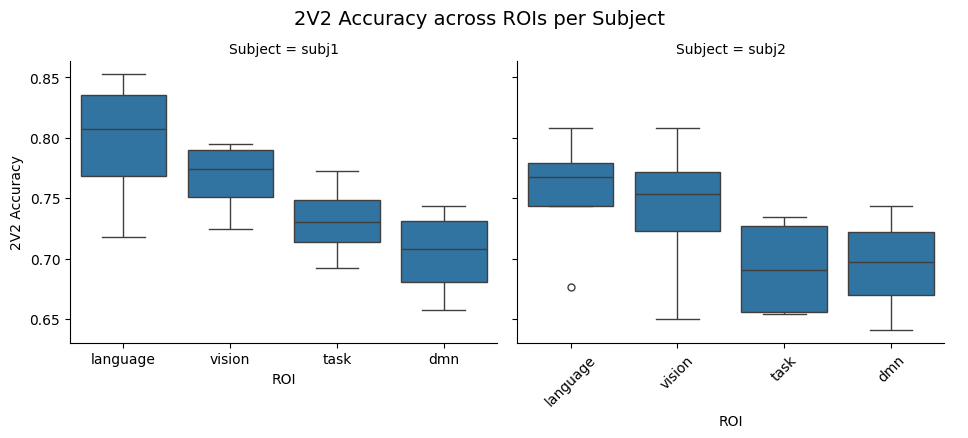

In [44]:
sns.catplot(
    data=results_df,
    x='ROI',
    y='2V2 Accuracy',
    col='Subject',
    kind='box',
    col_wrap=2,  # adjust depending on how many subjects
    height=4,
    aspect=1.2
)

plt.subplots_adjust(top=0.85)
plt.suptitle('2V2 Accuracy across ROIs per Subject', fontsize=14)
plt.xticks(rotation=45)
plt.show()

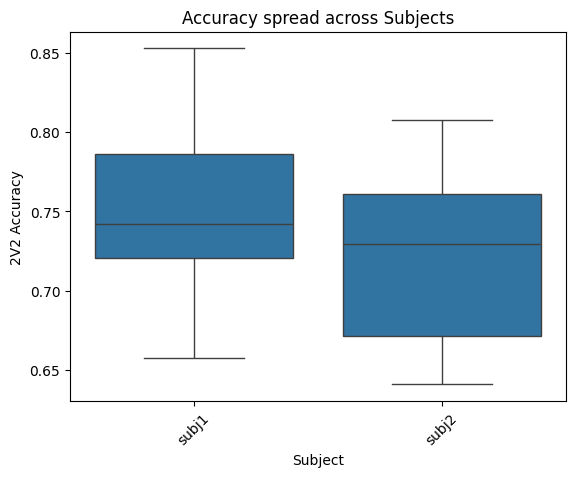

In [40]:
sns.boxplot(data=results_df, x='Subject', y='2V2 Accuracy')
plt.title('Accuracy spread across Subjects')
plt.xticks(rotation=45)
plt.show()

In [41]:
# WE USE THE BEST PERFORMING MODEL HERE THAT IS SBERT2

POS_tags = {'Nouns': 'NN', 'Verbs': 'VB', 'Adjectives': 'JJ'}

masked_results = []
for pos_name, pos_prefix in POS_tags.items():
    masked_sentences = mask_pos(stimuli, pos_prefix)
    masked_embeds = sbert_model2.encode(masked_sentences, show_progress_bar=False)
    
    for subj_name, subj_data in subjects.items():
        for roi in ROIs:
            print(f"Training for {subj_name} - {roi} with masked {pos_name}")
            Y = subj_data[roi]
            v2v, pc = train_encoder(masked_embeds, Y)
            masked_results.append({
                'Subject': subj_name,
                'ROI': roi,
                'POS Masked': pos_name,
                '2V2 Accuracy': v2v,
                'Pearson Correlation': pc
            })

Training for subj1 - language with masked Nouns
Training for subj1 - vision with masked Nouns
Training for subj1 - task with masked Nouns
Training for subj1 - dmn with masked Nouns
Training for subj2 - language with masked Nouns
Training for subj2 - vision with masked Nouns
Training for subj2 - task with masked Nouns
Training for subj2 - dmn with masked Nouns
Training for subj1 - language with masked Verbs
Training for subj1 - vision with masked Verbs
Training for subj1 - task with masked Verbs
Training for subj1 - dmn with masked Verbs
Training for subj2 - language with masked Verbs
Training for subj2 - vision with masked Verbs
Training for subj2 - task with masked Verbs
Training for subj2 - dmn with masked Verbs
Training for subj1 - language with masked Adjectives
Training for subj1 - vision with masked Adjectives
Training for subj1 - task with masked Adjectives
Training for subj1 - dmn with masked Adjectives
Training for subj2 - language with masked Adjectives
Training for subj2 - v

In [42]:
masked_df = pd.DataFrame(masked_results)

# save to csv
masked_df.to_csv('results_masked_encoder.csv', index=False)
print("Masked results saved to 'results_masked_encoder.csv'")

Masked results saved to 'results_masked_encoder.csv'


### MASKED - VISUALIZATION

/var/folders/4b/0_65g89n2yn9tmtywtpdt5900000gn/T/ipykernel_4702/3961269836.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=masked_df, x='POS Masked', y='2V2 Accuracy', ci='sd', ax=axes[0])
/var/folders/4b/0_65g89n2yn9tmtywtpdt5900000gn/T/ipykernel_4702/3961269836.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=masked_df, x='POS Masked', y='Pearson Correlation', ci='sd', ax=axes[1])


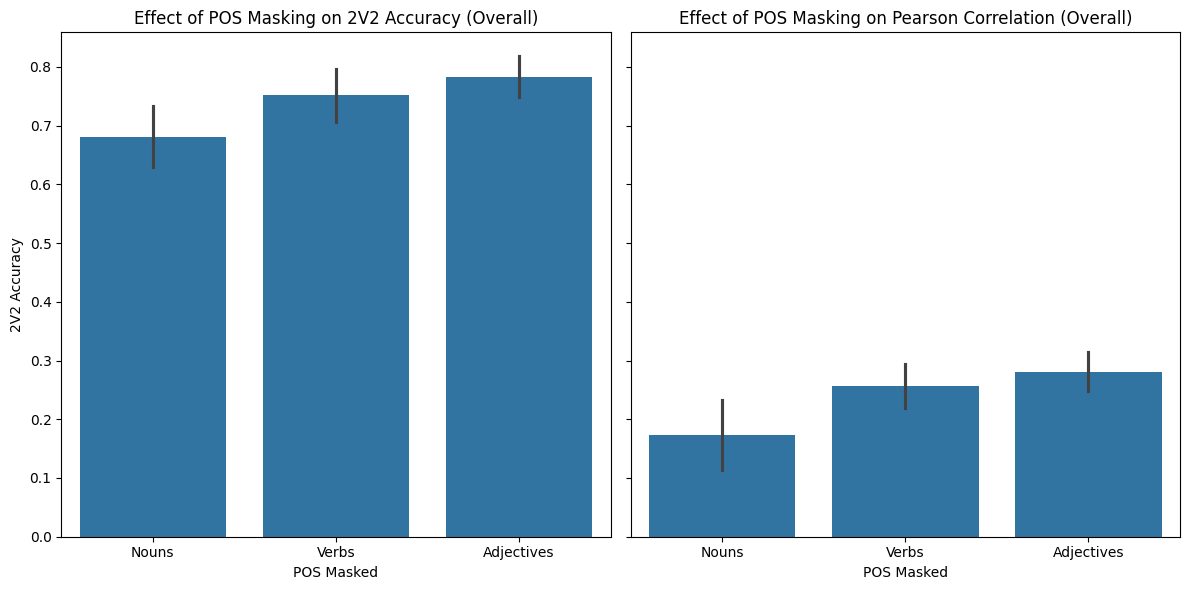

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for 2V2 Accuracy
sns.barplot(data=masked_df, x='POS Masked', y='2V2 Accuracy', ci='sd', ax=axes[0])
axes[0].set_title('Effect of POS Masking on 2V2 Accuracy (Overall)')
axes[0].set_ylabel('2V2 Accuracy')

# Plot for Pearson Correlation
sns.barplot(data=masked_df, x='POS Masked', y='Pearson Correlation', ci='sd', ax=axes[1])
axes[1].set_title('Effect of POS Masking on Pearson Correlation (Overall)')
axes[1].set_ylabel('Pearson Correlation')

plt.tight_layout()
plt.show()

/var/folders/4b/0_65g89n2yn9tmtywtpdt5900000gn/T/ipykernel_4702/3793252104.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=subj_data, x='POS Masked', y='2V2 Accuracy', ci='sd', ax=axs[i])
/var/folders/4b/0_65g89n2yn9tmtywtpdt5900000gn/T/ipykernel_4702/3793252104.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=subj_data, x='POS Masked', y='2V2 Accuracy', ci='sd', ax=axs[i])


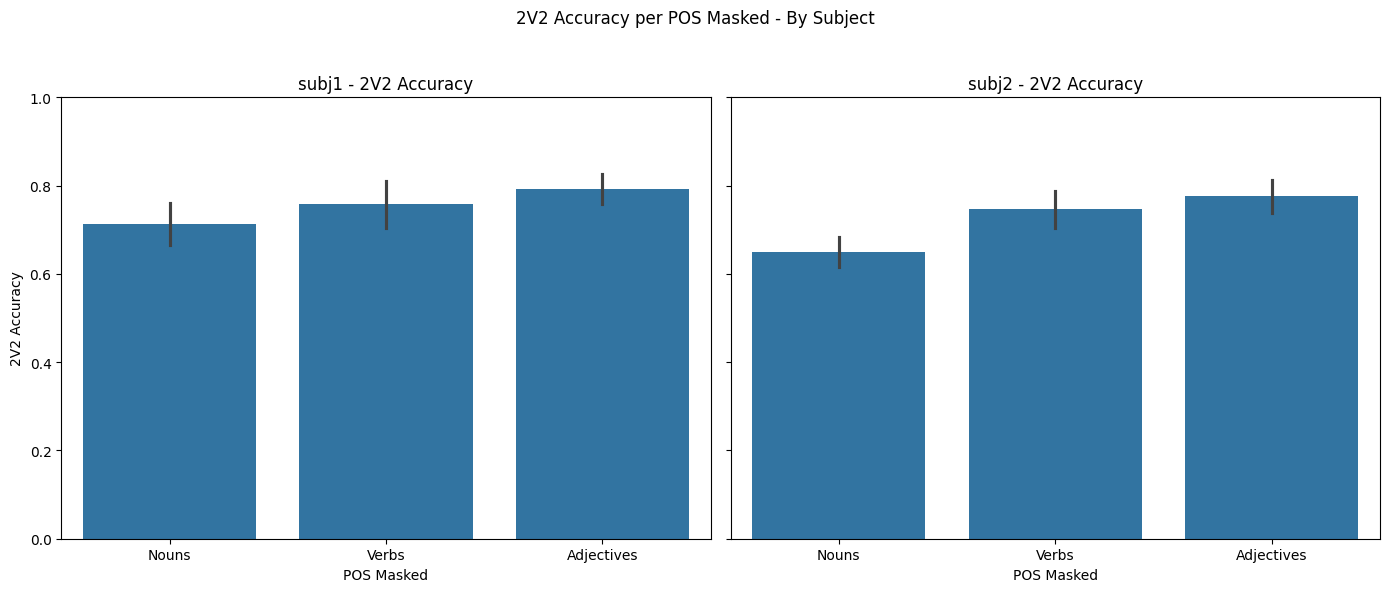

/var/folders/4b/0_65g89n2yn9tmtywtpdt5900000gn/T/ipykernel_4702/3793252104.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=subj_data, x='POS Masked', y='Pearson Correlation', ci='sd', ax=axs[i])
/var/folders/4b/0_65g89n2yn9tmtywtpdt5900000gn/T/ipykernel_4702/3793252104.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=subj_data, x='POS Masked', y='Pearson Correlation', ci='sd', ax=axs[i])


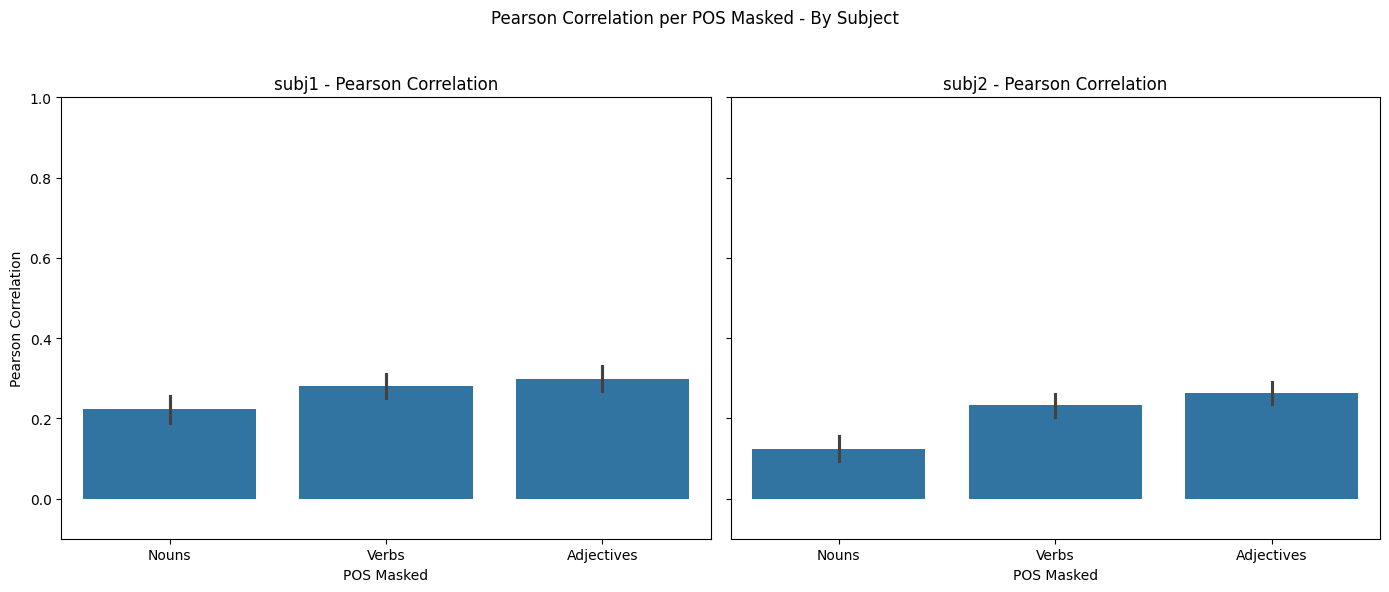

In [57]:
subjects = masked_df['Subject'].unique()
fig, axs = plt.subplots(1, len(subjects), figsize=(14, 6), sharey=True)

for i, subj in enumerate(subjects):
    subj_data = masked_df[masked_df['Subject'] == subj]
    sns.barplot(data=subj_data, x='POS Masked', y='2V2 Accuracy', ci='sd', ax=axs[i])
    axs[i].set_title(f'{subj} - 2V2 Accuracy')
    axs[i].set_ylim(0, 1)

plt.suptitle('2V2 Accuracy per POS Masked - By Subject')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Pearson correlation per subject
fig, axs = plt.subplots(1, len(subjects), figsize=(14, 6), sharey=True)

for i, subj in enumerate(subjects):
    subj_data = masked_df[masked_df['Subject'] == subj]
    sns.barplot(data=subj_data, x='POS Masked', y='Pearson Correlation', ci='sd', ax=axs[i])
    axs[i].set_title(f'{subj} - Pearson Correlation')
    axs[i].set_ylim(-0.1, 1)

plt.suptitle('Pearson Correlation per POS Masked - By Subject')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

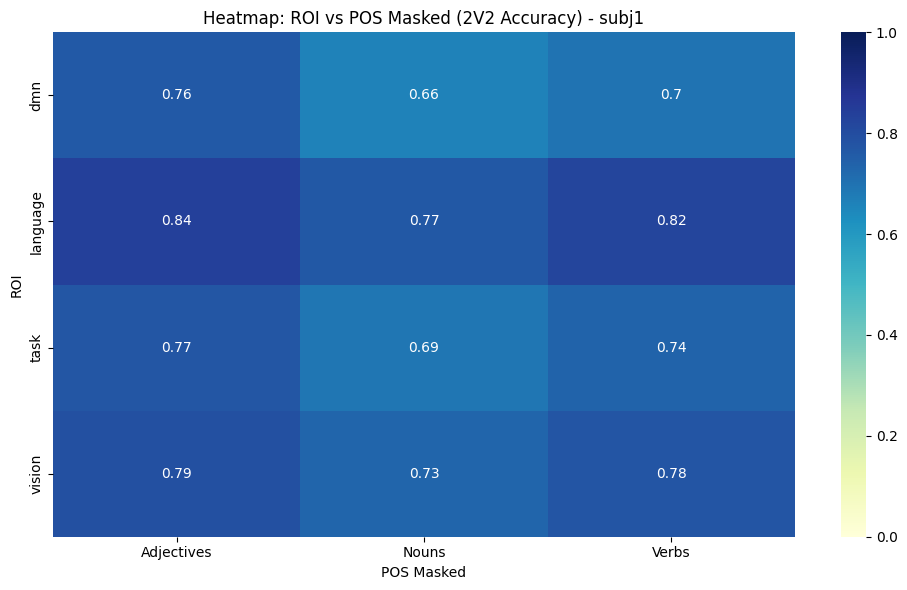

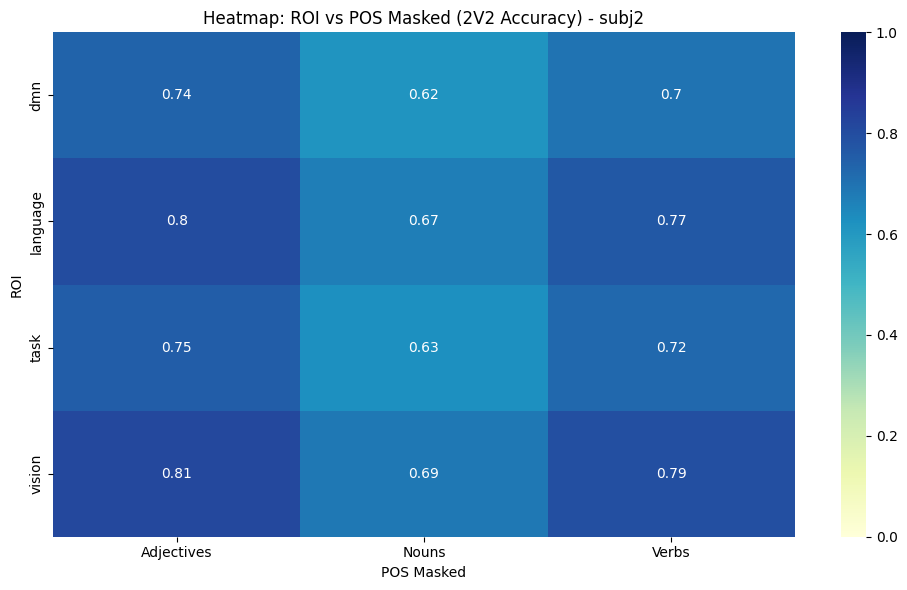

In [58]:
for subj in subjects:
    subj_data = masked_df[masked_df['Subject'] == subj]
    pivot = subj_data.pivot_table(index='ROI', columns='POS Masked', values='2V2 Accuracy')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
    plt.title(f'Heatmap: ROI vs POS Masked (2V2 Accuracy) - {subj}')
    plt.tight_layout()
    plt.show()

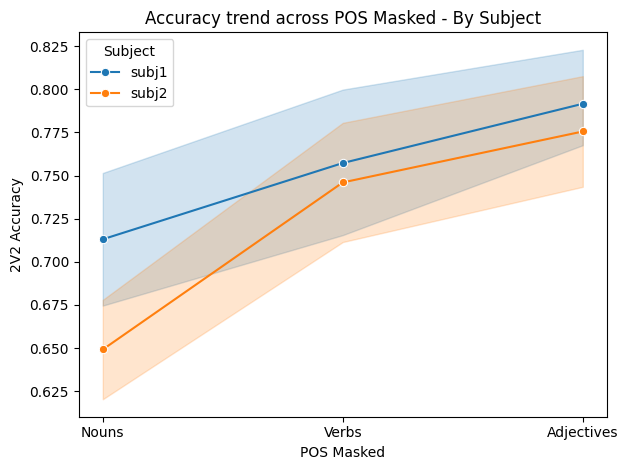

In [59]:
sns.lineplot(data=masked_df, x='POS Masked', y='2V2 Accuracy', hue='Subject', marker='o')
plt.title('Accuracy trend across POS Masked - By Subject')
plt.tight_layout()
plt.show()

- The results indicate that **Subject 2 consistently performs worse than Subject 1**, both with and without masking. This trend highlights potential individual differences in brain responses or model alignment.

- Across all cases, **masking nouns results in the worst performance** in terms of both 2V2 Accuracy and Pearson Correlation. This outcome aligns with expectations, as nouns often carry critical semantic information in sentences.

- The study was conducted for both subjects to ensure generalizability. However, the drop in performance when masking nouns underscores their importance in predicting brain activations.

- Masking other parts of speech, such as verbs and adjectives, also impacts performance but to a lesser extent compared to nouns. This suggests that while verbs and adjectives contribute to sentence meaning, nouns play a more central role in the studied tasks.

/var/folders/4b/0_65g89n2yn9tmtywtpdt5900000gn/T/ipykernel_3210/2170586143.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='Embedding', y='RSA', hue='Subject', ci='sd', palette='Set2')


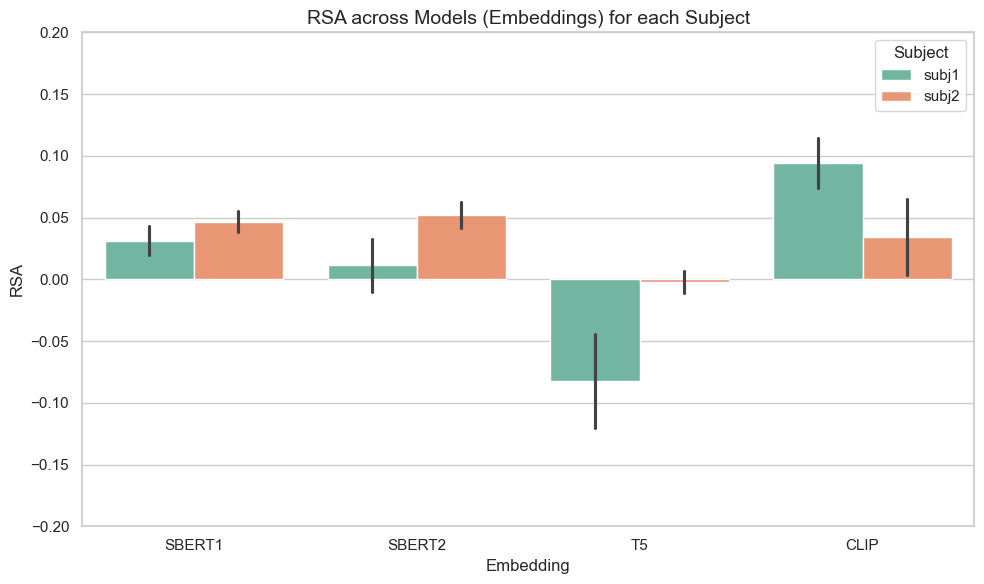

/var/folders/4b/0_65g89n2yn9tmtywtpdt5900000gn/T/ipykernel_3210/2170586143.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='ROI', y='RSA', hue='Subject', ci='sd', palette='Set1')


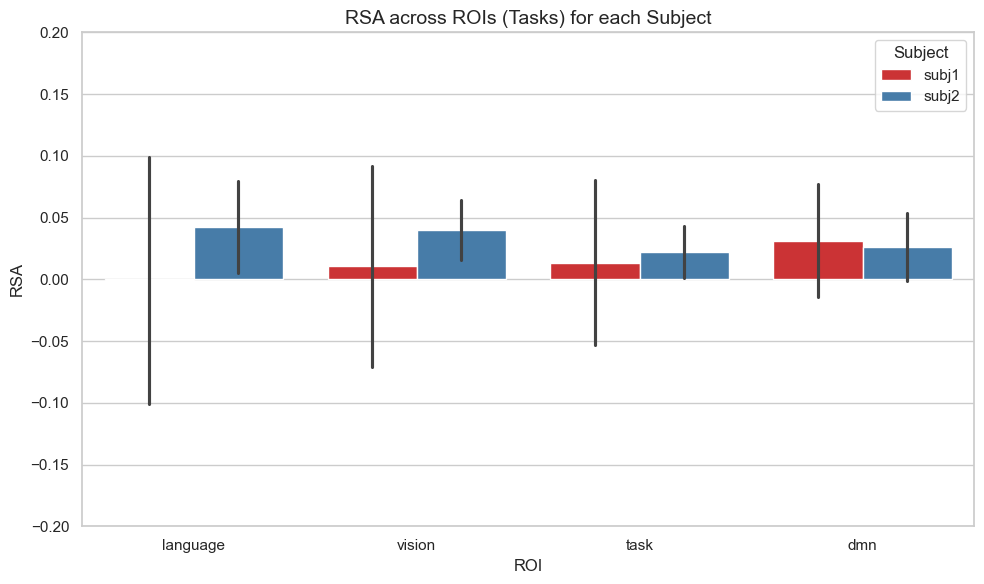

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV
csv_path = '/Users/prisha/Documents/SEM8_IIITH/CSAI/Assignment_4_2021101075/encode/results_non_masked_encoder.csv' 
df = pd.read_csv(csv_path)

sns.set(style="whitegrid")

# 1. RSA across different models (Embedding), separated by Subject
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Embedding', y='RSA', hue='Subject', ci='sd', palette='Set2')
plt.title('RSA across Models (Embeddings) for each Subject', fontsize=14)
plt.ylabel('RSA')
plt.ylim(-0.2, 0.2)
plt.legend(title='Subject')
plt.tight_layout()
plt.show()

# 2. RSA across different ROIs (Tasks), separated by Subject
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='ROI', y='RSA', hue='Subject', ci='sd', palette='Set1')
plt.title('RSA across ROIs (Tasks) for each Subject', fontsize=14)
plt.ylabel('RSA')
plt.ylim(-0.2, 0.2)
plt.legend(title='Subject')
plt.tight_layout()
plt.show()